Raw data: https://drive.google.com/drive/folders/1K-236nXkw35YVywHdJ2UrUH7LoBRPjF7?usp=sharing

In [2]:
pip install cbpro

In [3]:
#%%
import pandas as pd
import pickle
import base64
import cbpro
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
import bisect
import ast
from numpy.polynomial import Polynomial
from scipy import optimize
from scipy.special import binom
import numpy as np
from functools import reduce
import math

TIME_FORMAT = '%Y-%m-%d %H:%M:%S UTC'
FLIP_ADDR_1 = '0xd8a04F5412223F513DC55F839574430f5EC15531'
FLIP_ADDR_2 = '0xF32836B9E1f47a0515c6Ec431592D5EbC276407f'
TIME_FACTOR = 60 #minutes

class EthDaiRate(object):
    def __init__(self, rates):
        self.rates = rates
        self.time = [row[0] for row in rates]

    def find_lt(self, pivot):
        i = bisect.bisect_left(self.time, pivot)

        return self.rates[i][1]

def get_price_history():
    time = datetime.strptime("2019-11-12 00:00:00 UTC", TIME_FORMAT)
    end = datetime.strptime("2021-04-20 00:00:00 UTC", TIME_FORMAT)
    delta = timedelta(hours=4)

    client = cbpro.PublicClient()

    result = []
    while time < end:
        res = client.get_product_historic_rates(
            'ETH-DAI', 
            start=time, 
            end=time + delta, 
            granularity=60)

        result.extend(
            map(lambda x: (x[0], x[1]), res)
        )

        time += delta

    with open('eth-dai-all.pkl', 'wb+') as f:
        pickle.dump(result, f)

def get_utc_timestamp(time):
    return datetime.strptime(time, TIME_FORMAT).replace(tzinfo=timezone.utc)


## indecies of df should be reseted
def cluster_by_ops(df):
    prev_fn = None

    grab_flux_ops = []
    frob_fork_ops = []
    prev_frob_fork_ops = []

    for index, row in df.iterrows():
        fn = row['fn_name']
        src = row['src']
    
        if fn == 'grab':
            if (prev_fn == 'grab' or prev_fn == 'flux'):
                grab_flux_ops.append(row)
                continue

            if grab_flux_ops:
                yield (prev_frob_fork_ops, grab_flux_ops)

            grab_flux_ops = []
            prev_frob_fork_ops = frob_fork_ops
            frob_fork_ops = []

            grab_flux_ops.append(row)

        elif fn == 'flux':
            grab_flux_ops.append(row)

        else:
            frob_fork_ops.append(row)

        prev_fn = fn

    yield (prev_frob_fork_ops, grab_flux_ops)
    if frob_fork_ops:
        yield (frob_fork_ops, [])

def handle_grab_flux(grab_flux_ops, eth_dai_rate):
    dink_dai = 0
    flux_dai = 0
    dart_dai = 0
    total_dart = 0

    for row in grab_flux_ops:
        fn_name = row['fn_name']
        time = get_utc_timestamp(row['timestamp']).timestamp()

        if fn_name == 'grab':
            fold_rate = row['rate'] / 1e27
            dart = row['dart'] / 1e18
            total_dart += dart

            dtab = dart * fold_rate
            dart_dai += -dtab

            dink = -1 * row['dink'] / 1e18
            dink_dai += (dink * eth_dai_rate.find_lt(time))

        if fn_name == 'flux':
            wad = row['wad'] / 1e18
            ex_rate = eth_dai_rate.find_lt(time)
            flux_dai += (wad * ex_rate)

    lgd = (dink_dai - flux_dai) - dart_dai

    return lgd, total_dart

def handle_frob_fork(frob_fork_ops):
    total_dart = 0
    prev_time = get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp()
    params = []

    for row in frob_fork_ops:
        time = get_utc_timestamp(row['timestamp']).timestamp()
        dtime = (time - prev_time) / TIME_FACTOR ### should we consider diff time frame but I think no this formula consider every sub-individual transaction of each user
        prev_time = time

        fold_rate = row['rate'] / 1e27
        dart = row['dart'] / 1e18

        total_dart += dart

        dtab = dart * fold_rate

        params.append((dtab, dtime))

    return params, total_dart

def calculate_interest(params, init_tab):
    def p_or(x):
        total = init_tab
        for dtab, dt in params:
            total = (total * ((1 + x) ** dt) + dtab)

        return total

    def p(F, scale_factor):
        total = init_tab
        for dtab, dt in params:
            dT = dt / scale_factor
            total = (total * (F.real ** dT) + dtab)

        return total

    scale_factor = 20.0
    F = optimize.newton(lambda x: p(x, scale_factor), 1.0, maxiter=1000, tol=1e-10)
    r = 2 ** (np.log2(F) / scale_factor) - 1

    p_or_r = p_or(r)
    if abs(p_or_r) > 1e-4:
        scale_factor = 30.0
        F = optimize.newton(lambda x: p(x, scale_factor), 1.1, maxiter=1000, tol=1e-10)
        r = 2 ** (np.log2(F) / scale_factor) - 1

    return r


def split_frob_fork_ops(fork_frob_ops, init_art=0.0):
    def sum(acc, x):
        val = acc[-1] + x[1]['dart']
        acc.append(val)

        return acc
    
    vals = reduce(sum, fork_frob_ops.iterrows(), [0,])
    zeros = np.isclose(vals[1:], 0, atol=10, rtol=0)
    zeros = np.where(zeros == True)
    zeros = [x for x in zeros[0]]
    zeros.append(-1)

    loans = []
    prev_pos = 0
    index = ['usr', 'start', 'end', 'status'] ##, 'interest rate', 'LGD']
    for pos in zeros:
        loan = None
        status = None
        if pos != -1:
            loan = fork_frob_ops.iloc[prev_pos:pos+1]
            status = 'finished'
        else:
            loan = fork_frob_ops.iloc[prev_pos:]
            status = 'active'
            if len(loan) == 0:
                continue

        prev_pos = pos+1

        start = loan.iloc[0]['timestamp']
        end = loan.iloc[-1]['timestamp']
        usr = loan.iloc[0]['usr']
        data=[usr, start, end, status]
        loans.append(pd.Series(data=data, index=index))

    return loans

def get_results(df, eth_dai_rate):
    art = 0
    for frob_fork_ops, grab_flux_ops in cluster_by_ops(df):
        index = ['usr', 'start', 'end', 'status', 'interest rate', 'LGD']
        start = frob_fork_ops[0]['timestamp']
        vault = frob_fork_ops[0]['usr']
        end = None

        if not grab_flux_ops:
            data = [vault, start, end, 'active', None, None]
            yield pd.Series(data=data, index=index)
            continue

        init_rate = frob_fork_ops[0]['rate'] / 1e27
        init_tab = art * init_rate

        params, dart_ff = handle_frob_fork(frob_fork_ops)
        lgd, dart_gf = handle_grab_flux(grab_flux_ops, eth_dai_rate)

        art += dart_ff
        
        last_time_ff = get_utc_timestamp(frob_fork_ops[-1]['timestamp']).timestamp()
        first_time_gf = get_utc_timestamp(grab_flux_ops[0]['timestamp']).timestamp()
        dtime = (first_time_gf - last_time_ff) / TIME_FACTOR

        rate = grab_flux_ops[0]['rate'] / 1e27
        tab = art * rate

        params.append((-(tab + lgd), dtime))
        r = calculate_interest(params, init_tab)

        end = grab_flux_ops[-1]['timestamp']
        data = [vault, start, end, 'default', r, lgd]
        yield pd.Series(data=data, index=index)

        art += dart_gf

def filter_ethA_data(ethA):
    ethA_filtered = ethA[
        (ethA['fn_name'] == 'grab')
        |
        (
            (ethA['fn_name'] == 'flux')
            &
            (
                (ethA['src'] == FLIP_ADDR_1)
                |
                (ethA['src'] == FLIP_ADDR_2)
            )
        )
        |
        (
            (ethA['fn_name'] == 'frob')
            &
            (ethA['dart'] != 0.0)
        )
        |
        (
            (ethA['fn_name'] == 'fork')
            &
            (ethA['dart'] != 0.0)
        )
    ]

    ethA_filtered = ethA_filtered.astype({ 'rate': 'float' })

    fork_df = ethA_filtered[
        ethA_filtered['fn_name'] == 'fork'
    ]

    def decode(row):
        row['usr'] = row['src']
        row['src'] = None

        row['dart'] = -row['dart']

        return row

    fork_df_inv = fork_df.apply(decode, axis=1)

    return pd.concat([ethA_filtered, fork_df_inv], axis=0).sort_index()

# def get_statistics(df, eth_dai_rate):
#     # fold_rate = 10 ** 27
#     dink_dai = 0
#     flux_dai = 0
#     dart_dai = 0

#     params = []
#     pos = 0
#     params.append([])
#     # p(x) = a * x + b
#     # a = 0.0
#     # b = 0.0

#     final_op = df.iloc[-1]['fn_name']
#     prev_time = get_utc_timestamp(df.iloc[0]['timestamp']).timestamp()

#     art = 0.0
#     # final_tab = 0.0
#     # final_rate = df.iloc[-1]['rate'] / 1e27

#     for index, row in df.iterrows():
#         fn_name = row['fn_name']
#         fold_rate = row['rate']
#         time = get_utc_timestamp(row['timestamp']).timestamp()
#         # dtime = final_time - time
#         dtime = (time - prev_time) / 60
#         prev_time = time

#         if fn_name == 'grab':
#             dart = row['dart'] / 1e18
            
#             dtab = dart * (fold_rate / 1e27)
#             dart_dai += -dtab

#             dink = -1 * row['dink'] / 1e18
#             dink_dai += (dink * eth_dai_rate.find_lt(time))

#             # a += dtab * dtime
#             # b += dtab
#             final_tab = art * (fold_rate / 1e27)
#             params[pos].append((-final_tab, dtime))
#             art += dart

#             pos += 1
#             params.append([])
#             tab = art * (fold_rate / 1e27)
#             params[pos].append((tab, 0.0))


#         if fn_name == 'flux':
#             ex_rate = eth_dai_rate.find_lt(time)
#             flux_dai += ((row['wad'] / 1e18) * ex_rate)

#         if fn_name == 'frob' or fn_name == 'fork':
#             dart = row['dart'] / 1e18
#             art += dart

#             dtab = dart * (fold_rate / 1e27)

#             # a += dtab * dtime
#             # b += dtab
#             params[pos].append((dtab, dtime))

#     final_tab = 0.0
#     if final_op != 'grab':
#         final_tab = art * (fold_rate / 1e27)
    
#     lgd = (dink_dai - flux_dai) - dart_dai

#     # x = 0.0

#     # print (params)
#     # print ('tab', final_tab, art, (fold_rate / 1e27))

#     def power_series(x, k, N):
#         res = 0.0
#         for i in range(k):
#             coeff = binom(N, i)
#             res += coeff * (x ** i)

#         return res

#     def p(x):
#         # print ("x", x)
#         result = 0.0
#         for i in range(len(params)):
#             total = 0.0
#             for dtab, dt in params[i]:
#                 # print (dtab, dt)
#                 # total = (total * power_series(x, 2, dt) + dtab)
#                 # print ('{} * ((1 + x) ** {}) + {}'.format(total, dt, dtab))
#                 total = (total * ((1 + x) ** dt) + dtab)

        
#             result += total

#         return result - lgd - final_tab

#     # def f(F):
#     #     # print ("x", x)
#     #     result = 0.0
#     #     for i in range(len(params)):
#     #         total = 0.0
#     #         for dtab, dt in params[i]:
#     #             total = (total * (2 ** (dt * F)) + dtab)

        
#     #         result += total

#     #     return result - lgd - final_tab

#     x = optimize.newton(p, 0.0, maxiter=1000, tol=1e-10)

#     # print ('f(x)', f(x))

#     # x = (tab + lgd - b) / a

#     return x, lgd

# %%
eth_dai_rates = None
file_name = "ethA-dai-price.csv"
with open(file_name, 'rb+') as f:
    eth_dai_rates = pickle.load(f)

#%%
rate = EthDaiRate(eth_dai_rates)

# %%
file_name = "maker_vat_calls_ethA_2019-2021.csv"
ethA = pd.read_csv(file_name)

ethA_default = filter_ethA_data(ethA)

# %%
grouped = ethA_default.groupby('usr')
grab = ethA[ethA['fn_name'] == 'grab']
grab_usr = set(grab.groupby('usr').groups.keys())
other_usr = set(grouped.groups.keys()) - grab_usr

# get credits of users who weren't liquidated
loans_all = []
for v in tqdm(other_usr):
    v_gr = grouped.get_group(v)
    loans = split_frob_fork_ops(v_gr)
    
    loans_all.extend(loans)

pd.DataFrame(loans_all).to_csv('finished_credits.csv')

#%%
stat = []

# get credits of users who were liquidated at least once
for vault in tqdm(grab_usr):
    group = grouped.get_group(vault)

    stat.extend(
        [row for row in get_results(group, rate)]
    )

# %%
# loans = pd.DataFrame(stat)
#%%
# loans[loans['LGD'] > 0.0].to_csv('credits_original.csv')

100%|██████████| 235/235 [00:00<00:00, 339.12it/s]


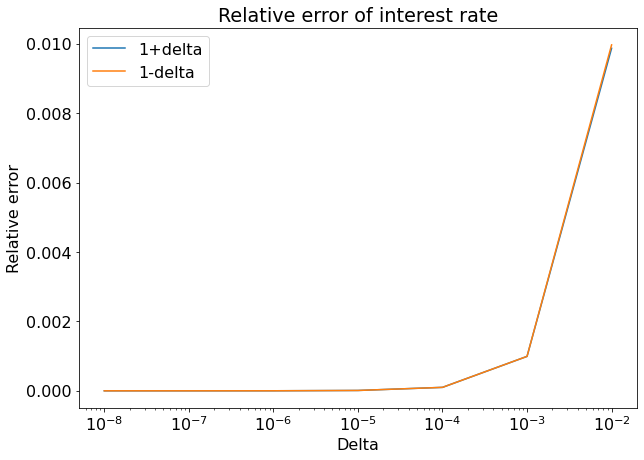

In [4]:
import matplotlib.pyplot as plt

# f_name = "credits_original.csv"
# credits = pd.read_csv(f_name)
credits = pd.DataFrame(stat)
delta = 1e-2
def find_delta(df, delta):
  my_dict_add, my_dict_minus = dict(), dict()
  for i in range(7):
      original_r = df['interest rate']
      modify_r_add = df['interest rate']*(1+delta)
      relative_add = abs(original_r-modify_r_add)/((original_r+modify_r_add)/2)
      my_dict_add[delta] = relative_add.mean()
      
      modify_r_minus = df['interest rate']*(1-delta)
      relative_minus = abs(original_r-modify_r_minus)/((original_r+modify_r_minus)/2)
      my_dict_minus[delta] = relative_minus.mean()
      
      delta = delta * 1e-1
  return my_dict_add, my_dict_minus

my_dict_add_orginal, my_dict_minus_original =find_delta(credits, delta) 

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams['font.size'] = '16'
plt.xlabel("Delta")
plt.ylabel("Relative error")
plt.title("Relative error of interest rate")
plt.semilogx(list(my_dict_add_orginal.keys()),list(my_dict_add_orginal.values()), label = "1+delta")
plt.semilogx(list(my_dict_minus_original.keys()),list(my_dict_minus_original.values()), label = "1-delta")
plt.legend()
plt.show()

In [5]:
# divided by factor = [ i**2 for i in range(1,11)]

import warnings
warnings.filterwarnings("ignore")
from decimal import Decimal

def handle_frob_fork_factor(frob_fork_ops, factor):
    total_dart = 0
    prev_time = get_utc_timestamp(frob_fork_ops[0]['timestamp']).timestamp()
    params = []

    for row in frob_fork_ops:
        time = get_utc_timestamp(row['timestamp']).timestamp()
        dtime = (time - prev_time) /(factor * TIME_FACTOR) ##
        prev_time = time

        fold_rate = row['rate'] / 1e27
        dart = row['dart'] / 1e18

        total_dart += dart

        dtab = dart * fold_rate

        params.append((dtab, dtime))

    return params, total_dart

def calculate_interest_disp(params, init_tab, factor):
    def p_or(x):
        total = init_tab
        for dtab, dt in params:
          if factor == 1/60:
            total = (total * float(pow(Decimal(F), Decimal(dt))) + dtab) ##
          else:
            total = round((total * float(pow(Decimal(F), Decimal(dt))) + dtab),2) ##

        return total

    def p(F, scale_factor):
        total = init_tab
        for dtab, dt in params:
            dT = dt / scale_factor
            if factor == 1/60:
              total = (total * float(pow(Decimal(F), Decimal(dt))) + dtab) ##
            else:
              total = round((total * float(pow(Decimal(F), Decimal(dT))) + dtab),2) ##

        return total

    scale_factor = 20.0
    if factor == 1/60:
      F = optimize.newton(lambda x: p(x, scale_factor), 1, maxiter=3000) 
    else:  
      F = optimize.newton(lambda x: p(x, scale_factor), 1.0, maxiter=1000, tol=1e-10, disp=False) ##
    r = 2 ** (np.log2(F) / scale_factor) - 1

    p_or_r = p_or(r)
    if abs(p_or_r) > 1e-4:
        scale_factor = 30.0
        if factor == 1/60:
          F = optimize.newton(lambda x: p(x, scale_factor), 1, maxiter=3000) 
        else:
          F = optimize.newton(lambda x: p(x, scale_factor), 1.1, maxiter=1000, tol=1e-10, disp=False) ##
        r = 2 ** (np.log2(F) / scale_factor) - 1

    return r

def get_results_factor(df, eth_dai_rate, factor):
    art = 0
    for frob_fork_ops, grab_flux_ops in cluster_by_ops(df):
        index = ['usr', 'start', 'end', 'status', 'interest rate', 'LGD']
        start = frob_fork_ops[0]['timestamp']
        vault = frob_fork_ops[0]['usr']
        end = None

        if not grab_flux_ops:
            data = [vault, start, end, 'active', None, None]
            yield pd.Series(data=data, index=index)
            continue

        init_rate = frob_fork_ops[0]['rate'] / 1e27
        init_tab = art * init_rate

        params, dart_ff = handle_frob_fork_factor(frob_fork_ops, factor)
        lgd, dart_gf = handle_grab_flux(grab_flux_ops, eth_dai_rate)

        art += dart_ff
        
        last_time_ff = get_utc_timestamp(frob_fork_ops[-1]['timestamp']).timestamp()
        first_time_gf = get_utc_timestamp(grab_flux_ops[0]['timestamp']).timestamp()
        dtime = (first_time_gf - last_time_ff) /(factor * TIME_FACTOR) ##

        rate = grab_flux_ops[0]['rate'] / 1e27
        tab = art * rate

        params.append((-(tab + lgd), dtime))
        r = calculate_interest_disp(params, init_tab, factor)

        end = grab_flux_ops[-1]['timestamp']
        data = [vault, start, end, 'default', r, lgd]
        yield pd.Series(data=data, index=index)

        art += dart_gf


#%%
stat = []
my_list_stat = [[] for i in range(1,12)] #10 list
factor = [1/60]
factor_inner = [ i**2 for i in range(1,11)]
factor.extend(factor_inner)
# get credits of users who were liquidated at least once
for i,s in tqdm(enumerate(my_list_stat)):
  for vault in (grab_usr):
      group = grouped.get_group(vault)
      s.extend(
          [row for row in get_results_factor(group, rate, factor[i])]
      )

for i, s in enumerate(my_list_stat):
  loans = pd.DataFrame(s).rename(columns={"interest rate": 'interest rate_{0}'.format((i)**2)})
  file_name_loan = 'credits_{0}'.format((i)**2)+'.csv'
  loans[loans['LGD'] > 0.0].to_csv(file_name_loan)

11it [00:40,  3.66s/it]


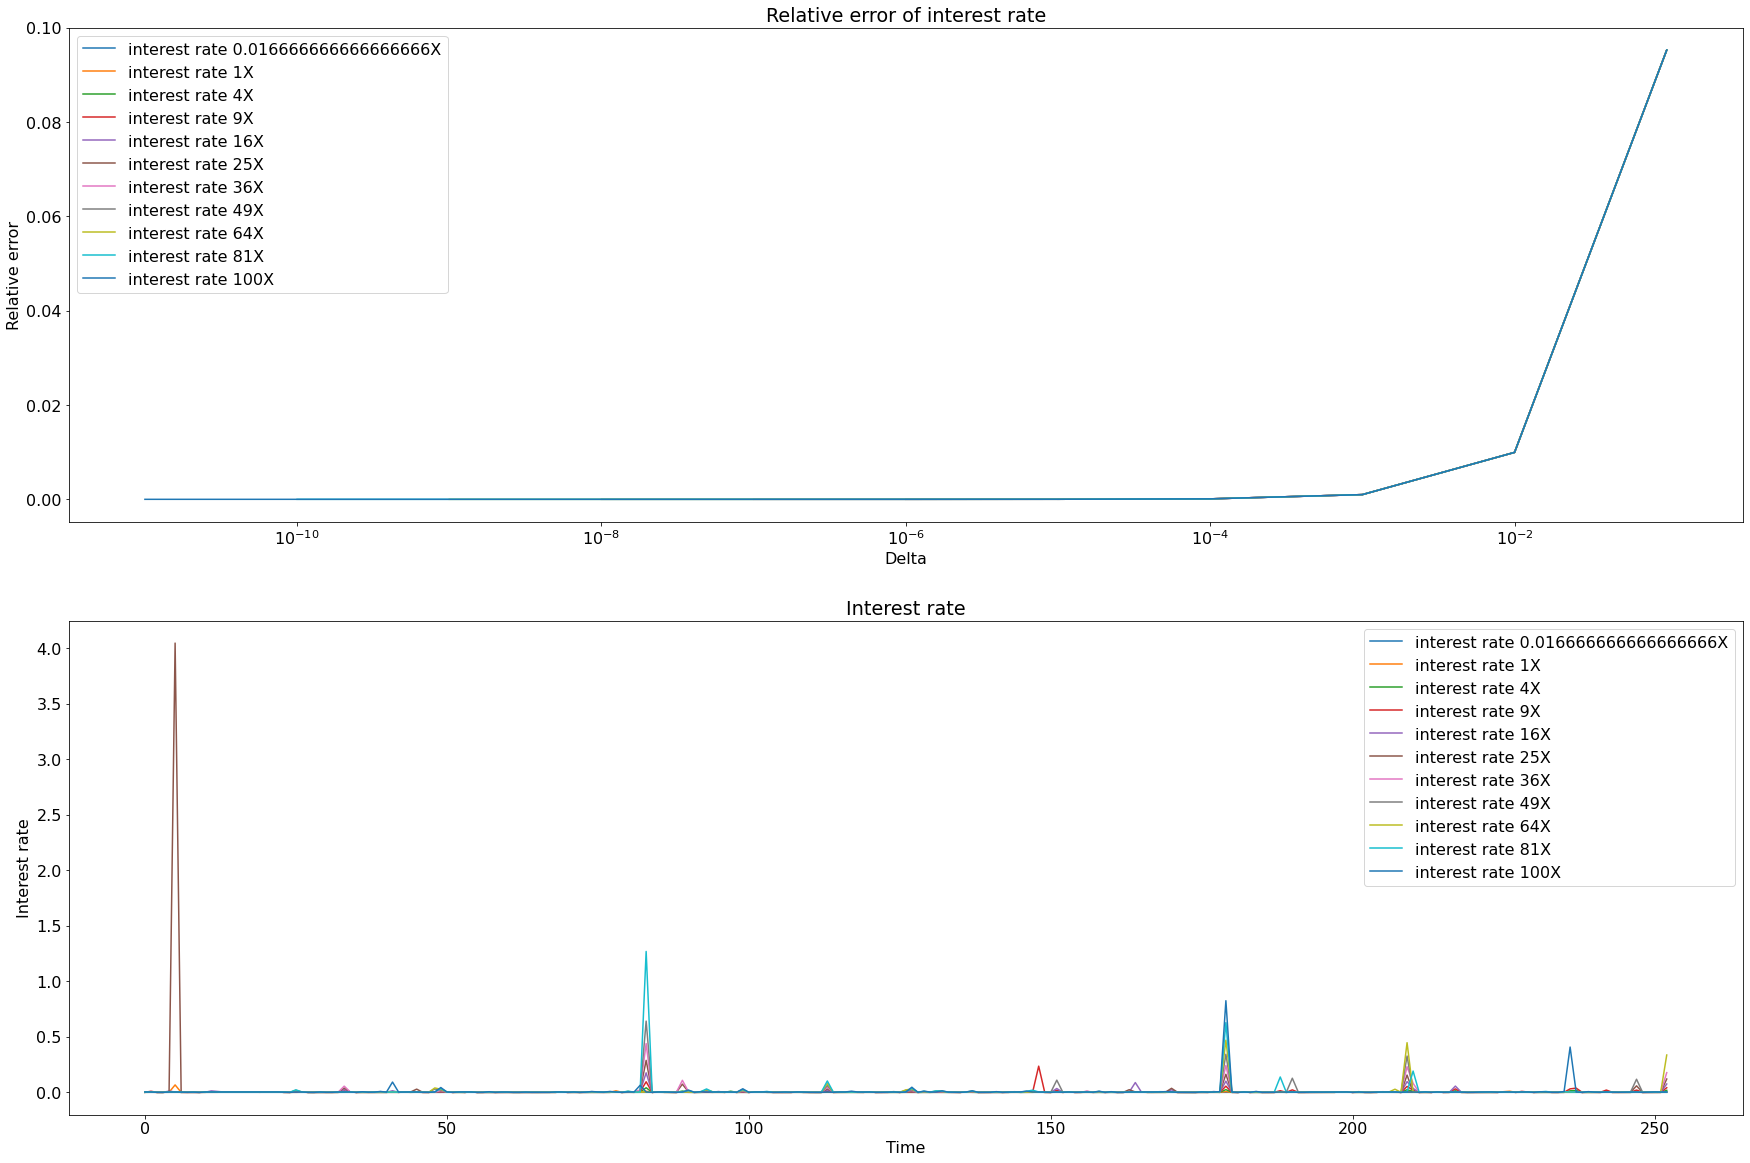

In [18]:
import matplotlib.pyplot as plt
import datetime
delta = 1e-1
my_dict_add, my_dict_minus = dict(), dict()
my_interest, my_start_date = [], []
pd_r = pd.DataFrame()
for j in range(len(my_list_stat)):
  fn = 'credits_{0}'.format((j)**2)+'.csv'
  file = pd.read_csv(fn)
  original_r = file['interest rate_{0}'.format((j)**2)]
  for i in range(7): # random number just 1e-1*1e-1   7 times
      modify_r_add = file['interest rate_{0}'.format((j)**2)]*(1+delta)
      relative_add = abs(original_r-modify_r_add)/((original_r+modify_r_add)/2)
      my_dict_add[delta] = relative_add.mean()
  my_interest.append(original_r)
  my_start_date.append(pd.to_datetime(file['start']).dt.date)
  pd_r = pd_r.append(original_r)
  delta = delta * 1e-1

  plt.rcParams["figure.figsize"] = (30,20)
  plt.rcParams['font.size'] = '16'
  plt.subplot(211)
  plt.semilogx(list(my_dict_add.keys()),list(my_dict_add.values()), label = 'interest rate {0}X'.format(factor[j]))
  plt.xlabel("Delta")
  plt.ylabel("Relative error")
  plt.title("Relative error of interest rate")
  plt.legend()
  plt.subplot(212)
  plt.plot(my_interest[j], label = 'interest rate {0}X'.format(factor[j]))
  plt.title("Interest rate")
  plt.ylabel("Interest rate")
  plt.xlabel("Time")
  plt.legend()
plt.show()


In [16]:
pd_r = pd_r.T
pd_r.columns =['interest_0', 'interest_1', 'interest_4', 'interest_9', 'interest_16','interest_25',
               'interest_36', 'interest_49', 'interest_64', 'interest_81','interest_100']  
pd_r      

,interest_0,interest_1,interest_4,interest_9,interest_16,interest_25,interest_36,interest_49,interest_64,interest_81,interest_100
0,0.000000e+00,0.000035,0.000139,0.000314,0.000557,0.000873,0.001255,0.001707,0.002231,0.002830,0.003185
1,8.900098e-07,0.001068,0.004282,0.009661,0.003185,0.003185,0.003185,0.003185,0.003185,0.003185,0.003185
2,0.000000e+00,0.000006,0.000025,0.000057,0.000101,0.000158,0.000227,0.000309,0.000404,0.000511,0.000632
3,0.000000e+00,0.000003,0.000010,0.000023,0.000042,0.000065,0.000094,0.000128,0.000167,0.000211,0.000261
4,5.788661e-07,0.000695,0.002782,0.006272,0.011180,0.003185,0.003185,0.003185,0.003185,0.003185,0.003185
...,...,...,...,...,...,...,...,...,...,...,...
248,0.000000e+00,0.000004,0.000017,0.000038,0.000067,0.000104,0.000150,0.000205,0.000267,0.000338,0.000418
249,0.000000e+00,0.000018,0.000073,0.000164,0.000291,0.000455,0.000656,0.000892,0.001166,0.001476,0.001822
250,0.000000e+00,0.000034,0.000137,0.000308,0.000547,0.000855,0.001232,0.001677,0.002191,0.002774,0.003425
251,0.000000e+00,0.000025,0.000101,0.000227,0.000403,0.000630,0.000906,0.001235,0.001612,0.002046,0.002522


In [17]:
# relative error between original and divied interest rate
for i in range(0,11):
  if i ==0:
    print(f"divided factor = 1/60, absoulte error = {(abs(pd_r.iloc[:, 1]- pd_r.iloc[:, 0])/pd_r.iloc[:, 1]).mean() }")
  else:
    print(f"divided factor = {i**2}, absoulte error = { (abs(pd_r.iloc[:, 1]- pd_r.iloc[:, i])/pd_r.iloc[:, 1]).mean() }")

divided factor = 1/60, absoulte error = 0.9992538394006569
divided factor = 1, absoulte error = 0.0
divided factor = 4, absoulte error = 2.6576589426358788
divided factor = 9, absoulte error = 7.091189436110005
divided factor = 16, absoulte error = 12.335729756907664
divided factor = 25, absoulte error = 19.30522704604672
divided factor = 36, absoulte error = 27.073125795344808
divided factor = 49, absoulte error = 36.33921133715973
divided factor = 64, absoulte error = 46.53479850779027
divided factor = 81, absoulte error = 59.634016300684486
divided factor = 100, absoulte error = 69.67488586765838
